Imports:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from scipy import ndimage

Important functions:

In [2]:
# show images using matplotlib
def sip(images, titles=[], image_size=256):
    if len(images) != len(titles) and len(titles) != 0:
        raise Exception('Number of images does not match the number of titles.')
    if isinstance(images, np.ndarray):
        raise Exception('Images parameter must be passed as an array.')
    fig = plt.figure(figsize=(image_size * len(images) / 100, image_size * len(images) / 100), dpi=100)
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i + 1)
        if len(titles) != 0:
            ax.set_title(titles[i])
        ax.set_axis_off()
        ax.set_aspect('equal')
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image, interpolation='none')
        else:
            ax.imshow(image, interpolation='none', cmap='gray')
    plt.tight_layout()
    plt.show()

# show image pixels value histogram
def show_hist(image, title="Histogram"):
    if len(image.shape) == 3:
        raise Exception("Image should be in gray level.")
    hist = np.zeros(256, dtype='uint8')
    for i in range(len(image)):
        for j in range(len(image[0])):
            hist[image[i][j]] += 1
    plt.xlabel("Pixel value")
    plt.ylabel("Number of occurrences")
    plt.title(title)
    plt.bar(range(256), hist)
    plt.show()

Let's load out images:

In [3]:
image = cv2.imread('water_cropped.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

That's how they look:

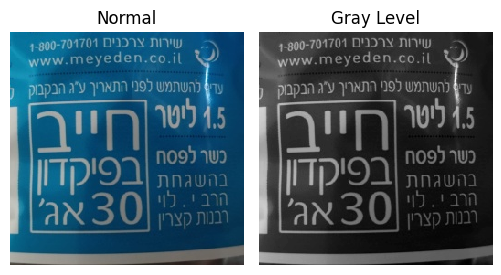

In [4]:
sip([image, image_gray], ['Normal', 'Gray Level'])

Let's first demonstrate the difference between each padding technique:

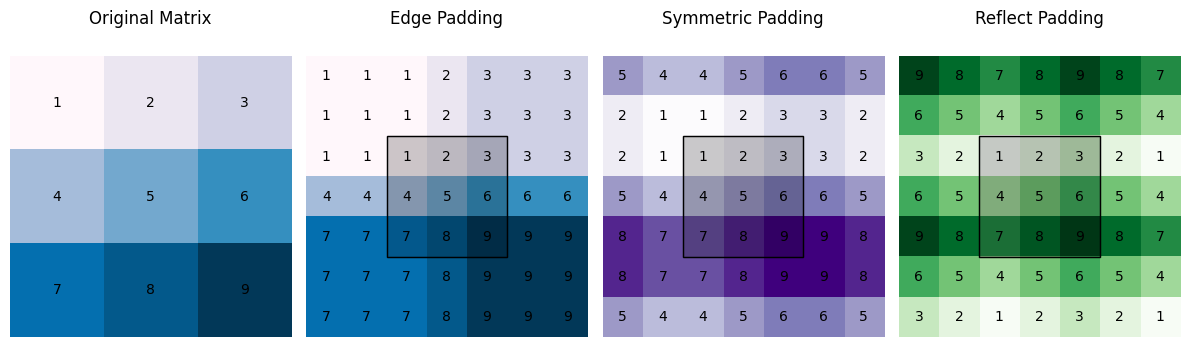

In [5]:
m = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

m_pad = np.pad(m, (2,2), 'edge')

# special thanks for www.tutorialspoint.com - plotting a matrix
# https://www.tutorialspoint.com/how-to-display-the-matrix-value-and-colormap-in-matplotlib

plt.rcParams["figure.figsize"] = [12, 12]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(1, 4, 1)
ax.matshow(m, cmap='PuBu')
for i in range(len(m)):
    for j in range(len(m[0])):
        c = m[j, i]
        ax.text(i, j, str(c), va='center', ha='center')
        ax.set_axis_off()
        ax.set_title('Original Matrix')

cmaps = ['PuBu', 'Purples', 'Greens']

for x, pad_type in enumerate(['edge', 'symmetric', 'reflect']):
    m_pad = np.pad(m, (2,2), pad_type)
    ax = fig.add_subplot(1, 4, x+2)
    ax.matshow(m_pad, cmap=cmaps[x])
    for i in range(len(m_pad)):
        for j in range(len(m_pad[0])):
            c = m_pad[j, i]
            ax.text(i, j, str(c), va='center', ha='center')
            ax.set_axis_off()
            ax.set_title(pad_type.capitalize() + ' Padding')

    rect = patches.Rectangle((1.5, 1.5), 3, 3, fill=True, alpha=0.2, color='black')
    ax.add_patch(rect)
    rect = patches.Rectangle((1.5, 1.5), 3, 3, fill=False, edgecolor='black')
    ax.add_patch(rect)

plt.show()

Now let's create our linear filter function:

In [6]:
def my_imfilter(s, filter, pad):
    # Get dimensions of input image and filter
    input_height, input_width = s.shape
    filter_height, filter_width = filter.shape

    # Calculate padding required for full padding
    padding_height = filter_height - 1
    padding_width = filter_width - 1
    
    if (pad not in ['edge', 'symmetric', 'reflect']):
        raise ValueError('Invalid value for parameter pad, use: \'edge\', \'symmetric\' or \'reflect\'')

    # Apply padding to the input image using np.pad
    padded_image = np.pad(s, ((padding_height, padding_height), (padding_width, padding_width)), mode = pad)
    
    # Calculate dimensions of the output feature map
    output_height = input_height + padding_height
    output_width = input_width + padding_width
    
    # Initialize an output matrix with zeros
    output = np.zeros((input_height + padding_height, input_width + padding_width), dtype=np.float32)
    
    for i in range(output_height):
        for j in range(output_width):
            window = padded_image[i:i+filter_height, j:j+filter_width]
            output[i, j] = np.sum(np.multiply(window, filter))
    
    # Crop the output to the original size
    cropped_output = output[padding_height:padding_height+input_height, padding_width:padding_width+input_width]
    
    return cropped_output.astype(np.uint8)

Let's define some filters that we will use very soon:

In [32]:
Laplacian_Filter1 = np.array([[0, 1, 0],
                              [1, -4, 1],
                              [0, 1, 0]], dtype=np.float32) / 9

Laplacian_Filter2 = np.array([[1, 1, 1],
                              [1, -8, 1],
                              [1, 1, 1]], dtype=np.float32) / 9

Laplacian_Filter3 = np.array([[0, -1, 0],
                              [-1, 4, -1],
                              [0, -1, 0]], dtype=np.float32) / 9

Laplacian_Filter4 = np.array([[-1, -1, -1],
                              [-1,  8, -1],
                              [-1, -1, -1]], dtype=np.float32) / 9

Smoothing_Filter = np.array([[1, 1, 1],
                             [1, 1, 1],
                             [1, 1, 1]], dtype=np.float32) / 9

# Applying smoothing filter

now let's apply the smoothing filter on our image:

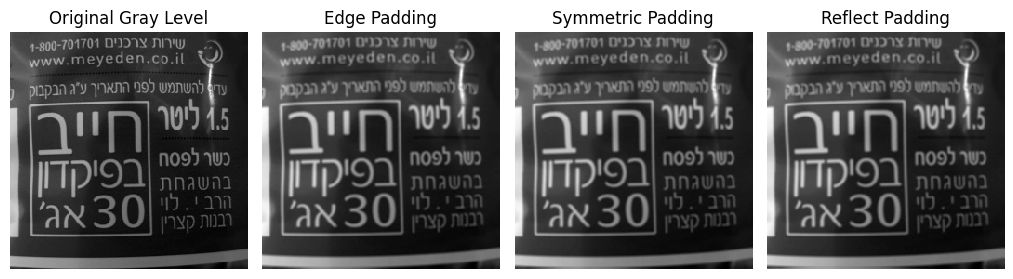

In [8]:
sip([
    image_gray,
    my_imfilter(image_gray, Smoothing_Filter, 'edge'),
    my_imfilter(image_gray, Smoothing_Filter, 'symmetric'),
    my_imfilter(image_gray, Smoothing_Filter, 'reflect'),
    ],
    [
    'Original Gray Level',
    'Edge Padding',
    'Symmetric Padding',
    'Reflect Padding'
    ])

#### Comparing my_imfilter vs scipy smoothing implementation:

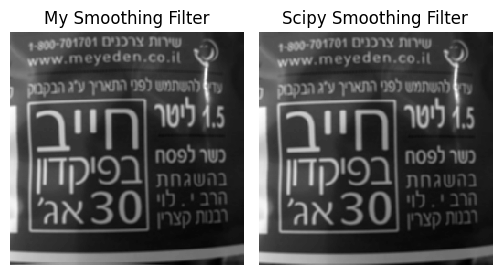

In [9]:
my_smoothing = my_imfilter(image_gray, Smoothing_Filter, 'reflect')
scipy_smoothing = ndimage.convolve(image_gray, Smoothing_Filter, mode='reflect')

sip([
    my_smoothing,
    scipy_smoothing
    ],
    [
    'My Smoothing Filter',
    'Scipy Smoothing Filter'
    ])

In [10]:
# benchmarking my_imfilter
st = time.time()
my_imfilter(image_gray, Smoothing_Filter, 'reflect')
et = time.time()
elapsed_time = et - st
print('my_imfilter - Execution time:', elapsed_time, 'seconds')

# benchmarking scipy
st = time.time()
my_imfilter(image_gray, Smoothing_Filter, 'reflect')
et = time.time()
elapsed_time = et - st
print('scipy       - Execution time:', elapsed_time, 'seconds')

my_imfilter - Execution time: 0.4412534236907959 seconds
scipy       - Execution time: 0.42960190773010254 seconds


Let's plot a Histogram (also known as cumulative distribution function) to compare the similarity:

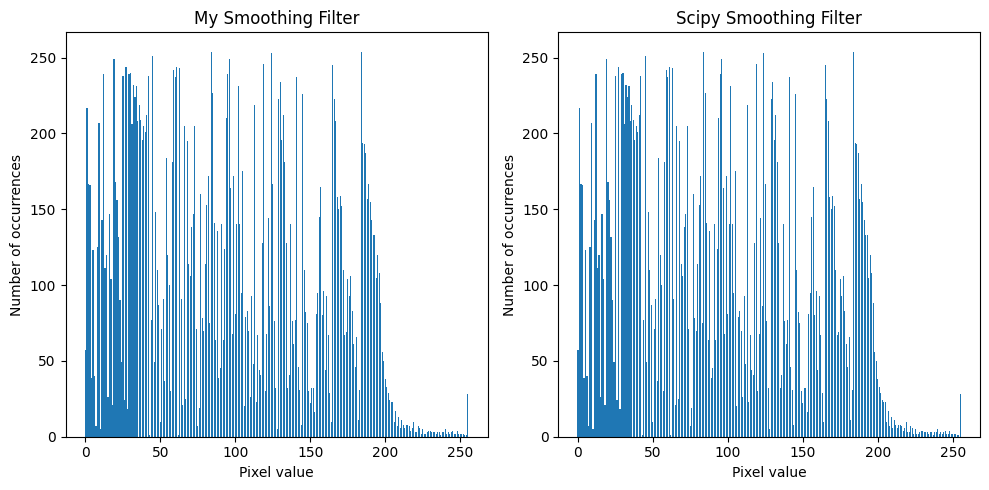

In [11]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
hist = np.zeros(256, dtype='uint8')
for i in range(len(image)):
    for j in range(len(image[0])):
        hist[image[i][j]] += 1
ax1.set_xlabel("Pixel value")
ax1.set_ylabel("Number of occurrences")
ax1.set_title('My Smoothing Filter')
ax1.bar(range(256), hist)

ax2 = fig.add_subplot(1, 2, 2)
hist = np.zeros(256, dtype='uint8')
for i in range(len(image)):
    for j in range(len(image[0])):
        hist[image[i][j]] += 1
ax2.set_xlabel("Pixel value")
ax2.set_ylabel("Number of occurrences")
ax2.set_title('Scipy Smoothing Filter')
ax2.bar(range(256), hist)

plt.show()

# Applying smoothing filter

There are 4 known Laplacian filters:

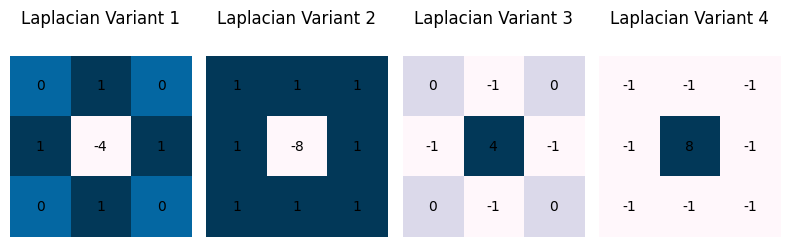

In [12]:
all_laplacian_filters = [Laplacian_Filter1, Laplacian_Filter2, Laplacian_Filter3, Laplacian_Filter4]
all_laplacian_filters_names = [Laplacian_Filter1, Laplacian_Filter2, Laplacian_Filter3, Laplacian_Filter4]
fig, axs = plt.subplots(1, 4, figsize=(8, 10))
axs[0].matshow(Laplacian_Filter1, cmap='PuBu')
axs[1].matshow(Laplacian_Filter2, cmap='PuBu')
axs[2].matshow(Laplacian_Filter3, cmap='PuBu')
axs[3].matshow(Laplacian_Filter4, cmap='PuBu')
for x in range(4):
    for i in range(3):
        for j in range(3):
            c = int(all_laplacian_filters[x][j, i] * 9)
            axs[x].text(i, j, str(c), va='center', ha='center')
            axs[x].set_axis_off()
            axs[x].set_title('{}{}'.format('Laplacian Variant ', x+1))

plt.show()

Here are the 4 variants of Laplacian filters, let's see what they gives:

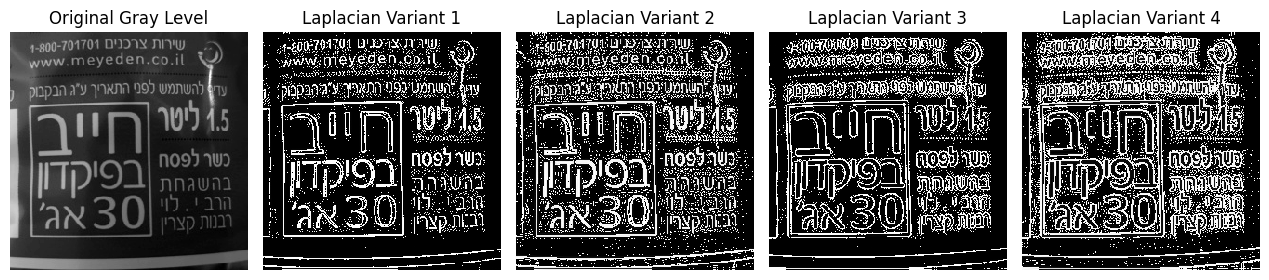

In [13]:
laplacian_v1 = my_imfilter(image_gray, Laplacian_Filter1, 'reflect')
laplacian_v2 = my_imfilter(image_gray, Laplacian_Filter2, 'reflect')
laplacian_v3 = my_imfilter(image_gray, Laplacian_Filter3, 'reflect')
laplacian_v4 = my_imfilter(image_gray, Laplacian_Filter4, 'reflect')

sip([
    image_gray,
    my_imfilter(image_gray, Laplacian_Filter1, 'reflect'),
    my_imfilter(image_gray, Laplacian_Filter2, 'reflect'),
    my_imfilter(image_gray, Laplacian_Filter3, 'reflect'),
    my_imfilter(image_gray, Laplacian_Filter4, 'reflect'),
    ],
    [
    'Original Gray Level',
    'Laplacian Variant 1',
    'Laplacian Variant 2',
    'Laplacian Variant 3',
    'Laplacian Variant 4'
    ])

Let's test all the Laplacian filters from before, apply them to an image, and see the difference in sharpness with 3 different alpha values:

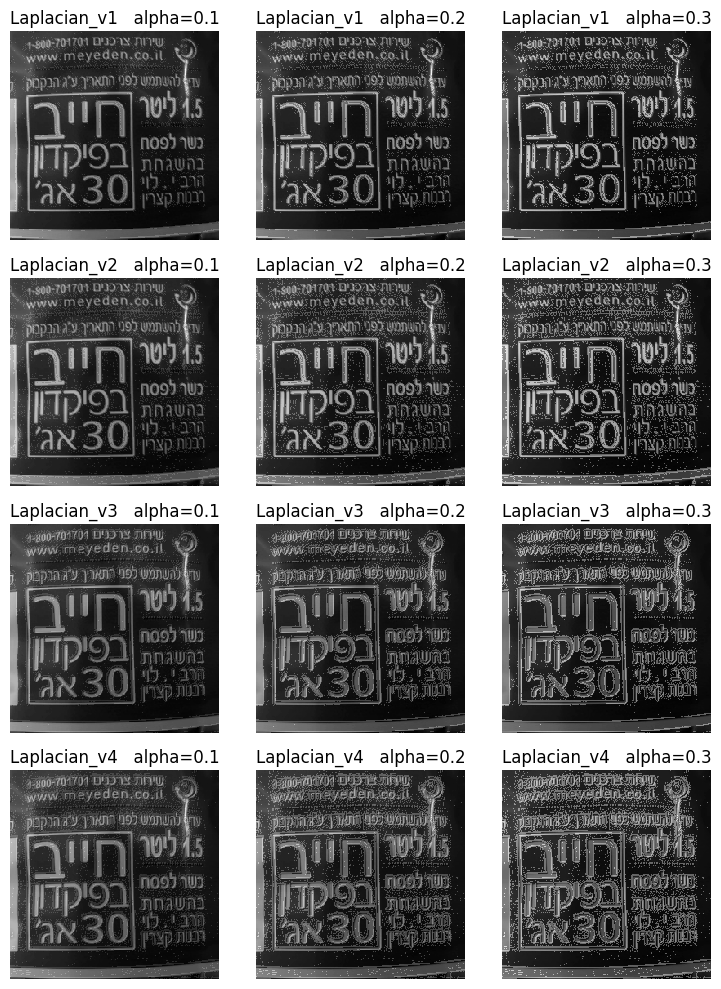

In [31]:
fig, axs = plt.subplots(4, 3, figsize=(8, 10))
t = cv2.imread('water_cropped.jpg', cv2.IMREAD_GRAYSCALE)

for i, laplacian_variant in enumerate([laplacian_v1, laplacian_v2, laplacian_v3, laplacian_v4], start=1):
    for j, alpha in enumerate([0.1, 0.2, 0.3], start=1):
        enhanced_image = cv2.addWeighted(image_gray, 1 - alpha, laplacian_variant, alpha, 0)
        axs[i-1,j-1].set_title('{}{}{}{}'.format('Laplacian_v', i, '   alpha=', alpha))
        axs[i-1,j-1].imshow(enhanced_image, interpolation='none', cmap='gray')
        axs[i-1,j-1].set_axis_off()
        axs[i-1,j-1].set_aspect('equal')
        

Let's use scipy Laplacian function:

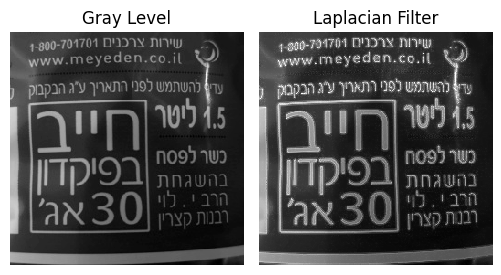

In [33]:
# Apply Laplacian filter to the grayscale image
laplacian = cv2.Laplacian(image_gray, cv2.CV_64F)
# Convert the Laplacian output to a suitable format for visualization
laplacian_visual = cv2.convertScaleAbs(laplacian)
# Resize the Laplacian visualization to match the original image size
laplacian_visual_resized = cv2.resize(laplacian_visual, (image.shape[1], image.shape[0]))
# Define a blending factor for combining the images
alpha = 0.7
# Enhance the original image by adding the Laplacian visualization
enhanced_image = cv2.addWeighted(image_gray, 1, laplacian_visual_resized, alpha, 0)

sip([image_gray, enhanced_image], ['Gray Level', 'Laplacian Filter'])

Let's benchmark the time of both Laplacian filters:

In [40]:
# benchmarking my_imfilter
st = time.time()
laplacian_v1 = my_imfilter(image_gray, Laplacian_Filter1, 'reflect')
my_filter_enhanced_image = cv2.addWeighted(image_gray, 1 - alpha, laplacian_variant, 0.1, 0)
et = time.time()
elapsed_time = et - st
print('my_imfilter - Execution time:', elapsed_time, 'seconds')

# benchmarking scipy
st = time.time()
laplacian = cv2.Laplacian(image_gray, cv2.CV_64F)
laplacian_visual = cv2.convertScaleAbs(laplacian)
laplacian_visual_resized = cv2.resize(laplacian_visual, (image.shape[1], image.shape[0]))
alpha = 0.7
scipy_enhanced_image1 = cv2.addWeighted(image_gray, 1, laplacian_visual_resized, alpha, 0)
et = time.time()
elapsed_time = et - st
print('scipy       - Execution time:', elapsed_time, 'seconds')

my_imfilter - Execution time: 0.4784102439880371 seconds
scipy       - Execution time: 0.0009701251983642578 seconds


Let's see the differences pixels different between the algorithms, with a histogram:

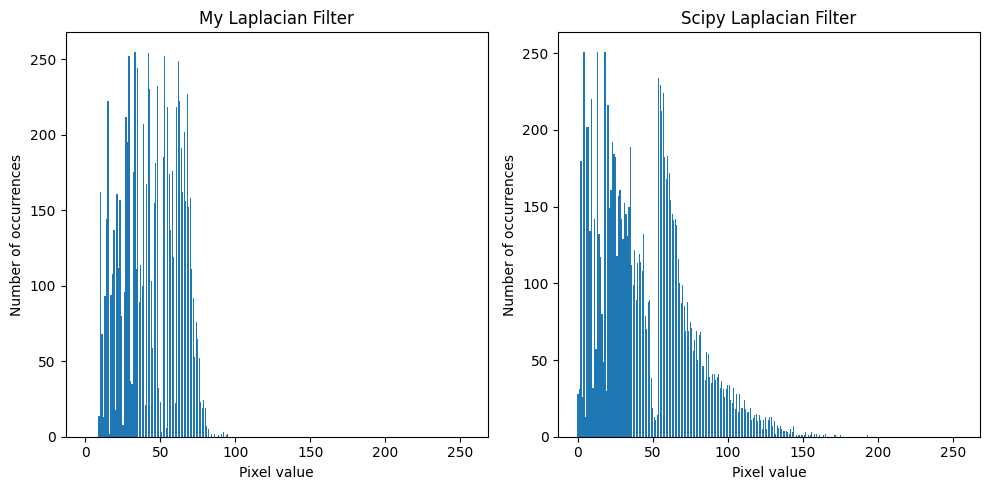

In [42]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
hist = np.zeros(256, dtype='uint8')
for i in range(len(my_filter_enhanced_image)):
    for j in range(len(my_filter_enhanced_image[0])):
        hist[my_filter_enhanced_image[i][j]] += 1
ax1.set_xlabel("Pixel value")
ax1.set_ylabel("Number of occurrences")
ax1.set_title('My Laplacian Filter')
ax1.bar(range(256), hist)

ax2 = fig.add_subplot(1, 2, 2)
hist = np.zeros(256, dtype='uint8')
for i in range(len(laplacian_visual_resized)):
    for j in range(len(laplacian_visual_resized[0])):
        hist[laplacian_visual_resized[i][j]] += 1
ax2.set_xlabel("Pixel value")
ax2.set_ylabel("Number of occurrences")
ax2.set_title('Scipy Laplacian Filter')
ax2.bar(range(256), hist)

plt.show()

In [59]:
def my_compose2(s1, s2, m=3):
    # Resize both images to 256x256
    s1 = cv2.cvtColor(cv2.resize(s1, (256, 256)), cv2.COLOR_BGR2GRAY)
    s2 = cv2.cvtColor(cv2.resize(s2, (256, 256)), cv2.COLOR_BGR2GRAY)

    # If m is outside of the valid values change it to 3
    if m < 0 or m > 8:
        m=3

    # Combine the images based on the amount of m given
    combined_image = (s1 >> (8 - m)) << (8 - m)  # Seperating the m high bits from s1
    combined_image += ((s2 << m) >> m)  # Seperating the (8-m) low bits from s2 and combining them with the high bits from s1

   

    return combined_image.astype(np.uint8)

In [122]:
def my_compose(s1, s2, m=3):

    # Assert invalid m value
    if (m < 0 or m > 8):
        raise ValueError('Parameter \'m\' must be between 0 and 8.')

    # Resize to 256x256, just in case
    s1 = cv2.resize(s1, (256, 256))
    s2 = cv2.resize(s2, (256, 256))

    # Turns the images to gray level, just in case
    s1 = cv2.cvtColor(s1, cv2.COLOR_BGR2GRAY)
    s2 = cv2.cvtColor(s2, cv2.COLOR_BGR2GRAY)

    mask_s1 = 255 - (255 >> 3) # m bits of '1' from left (MSB)
    mask_s2 = (255 >> 3) # 8-m bits of '1' from right (LSB)

    # Apply masks on s1 and s1, and craft the composed_image
    composed_image = s1 & mask_s1
    composed_image += s2 & mask_s2
    
    return composed_image.astype(np.uint8)

In [121]:
image1 = cv2.imread('water_cropped.jpg')
image2 = cv2.imread('keyboard_cropped.jpg')

a = my_compose2(image1, image2)
b = my_compose(image1, image2)

np.array_equal(a,b)

True

False

In [50]:


a = my_compose(image1, image2)

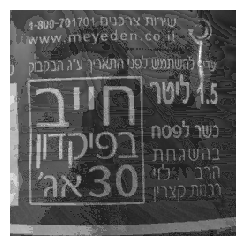

In [51]:
sip([a])